# XGBoost

In this tutorial we learn how to process data, train an XGBoost model and validate any model.

# Import packages

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from pathlib import Path

In [6]:
# set width of Jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# set some visual properties of displaying pandas DataFrame
pd.options.display.max_columns=200
pd.options.display.max_rows=200

# zkousim, jestli to delam spravne

**Download the data if needed (and unpack it into the Data folder), we use the same dataset as in the python intro:** <a href="https://www2.karlin.mff.cuni.cz/~kozmikk/files/data_devsample.zip" target="_blank">credit risk data</a> 

# Load Data
- Data sample represents data used in financial institutions for development of credit risk scoring models.
- This data sample was used in Kaggle competition arranged by Home Credit Group in 2018.
- Data includes binary target variable `TARGET` and multiple regressors to be used in model.
- Column `SK_ID_CURR` is used as unique identifier of credit application and columns `TIME` represents time of the application.
- Model should predict solvency of applicants at the time of application for credit.

In [170]:
# Load data - set index column, decimal point, separator
data_file = Path("../Assigment1/Data1/2024_DS2_HW1_data_train.csv")
data = pd.read_csv(data_file, sep = ',', decimal = '.', index_col = 'Booking_ID')

# print time of data being loaded - use strftime
print(f'Data loaded on:   {datetime.datetime.now().strftime(format="%Y-%m-%d %H:%M:%S")}')

Data loaded on:   2024-04-19 22:29:50


In [171]:
data.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
Booking_ID,,,,,,,,,,,,,,,,,,
INN10204,NaN,NaN,NaN,2.0,Meal Plan 2,NaN,Room_Type 6,NaN,2018.0,9.0,NaN,Online,0.0,0.0,NaN,NaN,1.0,0.0
INN20020,NaN,NaN,NaN,2.0,Meal Plan 1,NaN,NaN,NaN,NaN,12.0,NaN,Online,0.0,0.0,0.0,NaN,NaN,0.0
INN16435,1.0,NaN,NaN,2.0,NaN,0.0,Room_Type 1,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,0.0
INN07143,3.0,NaN,NaN,3.0,NaN,NaN,NaN,100.0,2018.0,5.0,NaN,Online,0.0,0.0,NaN,NaN,2.0,0.0
INN20511,1.0,0.0,1.0,1.0,Meal Plan 1,0.0,NaN,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,0.0,150.0,NaN,1.0


In [172]:
# Print some numbers about data sample size
print(f'Number of rows:   {data.shape[0]:,}'.replace(',', ' '))
print(f'Number of unique indexes:   {data.index.nunique():,}'.replace(',', ' '))
print(f'Number of columns:   {data.shape[1]:,}'.replace(',', ' '))

Number of rows:   32 647
Number of unique indexes:   32 647
Number of columns:   18


# Metadata Definitions

In [173]:
# check values in column booking_status
data.booking_status.value_counts(dropna=False)

booking_status
0.0    21774
1.0    10521
NaN      352
Name: count, dtype: int64

In [174]:
#tohle zatím nevím k čemu je

#name of the target column
col_target = "booking_status"
#name of the time column - nemáme?
# col_time = "TIME"

#name of the month column
col_month = "arrival_month"

In [175]:
# define list of predictors
cols_pred = list(data.columns[0:-1])

# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']

print('Numerical predictors:')
print('---------------------')
print(data[cols_pred_num].dtypes)
print()
print('Categorical predictors:')
print('-----------------------')
print(data[cols_pred_cat].dtypes)

Numerical predictors:
---------------------
no_of_adults                            float64
no_of_children                          float64
no_of_weekend_nights                    float64
no_of_week_nights                       float64
required_car_parking_space              float64
lead_time                               float64
arrival_year                            float64
arrival_month                           float64
arrival_date                            float64
repeated_guest                          float64
no_of_previous_cancellations            float64
no_of_previous_bookings_not_canceled    float64
avg_price_per_room                      float64
no_of_special_requests                  float64
dtype: object

Categorical predictors:
-----------------------
type_of_meal_plan      object
room_type_reserved     object
market_segment_type    object
dtype: object


In [176]:
# convert col_time to date - nepotřebujeme
#if data[col_time].dtype == 'O':
#    data[col_time] = data[col_time].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())

# Data Split

In [177]:
# define function to plot default rate in time for different samples
def default_rate_in_time_per_sample(dt, col_target, col_month, col_sample):
    # group by over month and sample
    dt_grp = dt.groupby([col_month, col_sample]).agg(
        def_rt = (col_target, 'mean')
    ).reset_index()
    
    # pivot sample values to columns
    dt_grp_pivot = dt_grp.pivot(index = col_month, columns = col_sample, values = 'def_rt')

    # plot default rate in time
    lines = plt.plot(range(len(dt_grp_pivot)), dt_grp_pivot, marker = 'o')
    plt.xticks(range(len(dt_grp_pivot)), dt_grp_pivot.index, rotation = 90)
    # set legend
    plt.legend(iter(lines), tuple(dt_grp_pivot.columns), loc='best', bbox_to_anchor=(1.05, 1))
    
    plt.ylim([0, 0.6])
    plt.ylabel('default rate')
    plt.xlabel('month')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(axis='y', colors='gray')
    ax.tick_params(axis='x', colors='gray')
        
    plt.show()

In [371]:
len(data[col_month])-1

32646

In [372]:
data[col_month].fillna(13, inplace=True)

C:\Users\vojta\AppData\Local\Temp\ipykernel_12120\3201418845.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col_month].fillna(13, inplace=True)


In [178]:
data['sample'] = 'default'

# define 'hoot' and 'oot' sample
#nemáme, doufám

#!!!ODSTRANÍ ŘÁDKY KDE JE BOOKING_STATU MIMO [0,1]!!!


# define intime mask
target_mask = (data[col_target] >= 0) & (data[col_target] <= 1)
# use train_test_split to split the intime into train and rest (don't forget seed); use stratification
data_train, data_valid = train_test_split(data[target_mask], test_size=0.1, random_state = 12, stratify = (data[target_mask][[col_target]])) #(data[target_mask][[col_month, col_target]])) #
data.loc[data_train.index, 'sample'] = 'train'
data.loc[data_valid.index, 'sample'] = 'valid'
# use train_test_split to split the rest into valid and test (don't forget seed); use stratification
# data_valid, data_test = train_test_split(data_rest, test_size=0.5, random_state = 12, stratify = (data_rest[[col_target]])) #(data_rest[[col_month, col_target]])) #
# data.loc[data_valid.index, 'sample'] = 'valid'
# data.loc[data_test.index, 'sample'] = 'test'

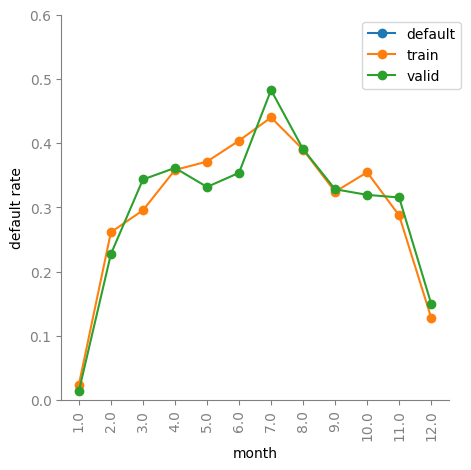

In [396]:
default_rate_in_time_per_sample(data, col_target, col_month, 'sample')

In [375]:
data[col_month].replace(13, np.nan, inplace=True)
data_train[col_month].replace(13, np.nan, inplace=True)
data_valid[col_month].replace(13, np.nan, inplace=True)
data_test[col_month].replace(13, np.nan, inplace=True)

C:\Users\vojta\AppData\Local\Temp\ipykernel_12120\400422843.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col_month].replace(13, np.nan, inplace=True)
C:\Users\vojta\AppData\Local\Temp\ipykernel_12120\400422843.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

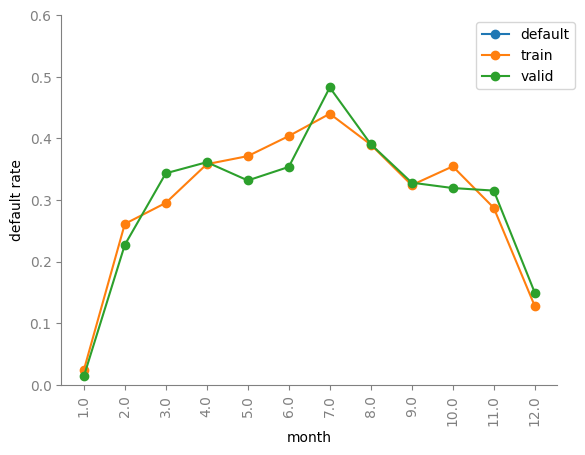

In [16]:
default_rate_in_time_per_sample(data, col_target, col_month, 'sample')

## Define Sample Masks

In [179]:
# define sample masks
train_mask = (data['sample'] == 'train')
valid_mask = (data['sample'] == 'valid') 
#test_mask = (data['sample'] == 'test') 
#oot_mask = (data['sample'] == 'oot')  
#hoot_mask = (data['sample'] == 'hoot')

# Data preprocessing

## Replace infinity

In [180]:
# v našich datech žádné nejsou

# find columns with infinity values
cols_with_inf = []
for col in cols_pred_num:
    if np.any(np.isinf(data[col])):
        cols_with_inf.append(col)
        print(f'Column {col} includes infinity values.')

# find columns with negative infinity values
cols_with_neginf = []
for col in cols_pred_num:
    if np.any(np.isneginf(data[col])):
        cols_with_neginf.append(col)
        print(f'Column {col} includes negative infinity values.')

In [181]:
# replace infinity values
for col in cols_with_inf:
    data[col] = data[col].replace(np.inf, 9999999)

## Encode Categorical Predictors
- Category encoding is defined by:
$$ CategoryEncoding = \frac{f_{categ}\cdot Booking_{category} + \alpha \cdot Booking}{f_{categ} + \alpha} $$
where $f_{categ}$ is frequency of category to be encoded, $Booking_{category}$ average booking status in this category and $Booking$ is overall average booking status.

In [182]:
def mean_target_encoding(dt, predictor, target, alpha = 0.01):
    total_cnt = len(dt)
    total_booking = np.mean(dt[target])
    dt_grp = dt.groupby(predictor).agg(
        categ_booking = (target, 'mean'),
        categ_cnt = (target, len)
    )
    
    dt_grp['categ_freq'] = dt_grp['categ_cnt'] / total_cnt
    dt_grp['categ_encoding'] = (dt_grp['categ_freq'] * dt_grp['categ_booking'] + alpha * total_booking) / (dt_grp['categ_freq'] + alpha)
    
    return dt_grp[['categ_encoding']].to_dict()['categ_encoding']

In [183]:
total_booking = np.mean(data[train_mask][col_target])

#jestli to chápu správně, tak ta if podmínka je nesplnitelná, takže to používá ten druhý postup, což je mean target encoding, můžeme přenastavit na one-hot otočením podmínky
# encode categorical predictors
for pred in tqdm(cols_pred_cat):
    if len(data[pred].unique()) < 0:
        dummies = pd.get_dummies(
            data[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data.columns:
                del data[d]
                
        data = data.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred:
                cols_pred.append(col)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target
        )

        additional_values = set(data[data[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_booking

        data['MTE_' + pred] = data[pred].map(new_vals)
        
        if 'MTE_' + pred not in cols_pred:
            cols_pred.append('MTE_' + pred)
        
        if pred in cols_pred:
            cols_pred.remove(pred)

  0%|          | 0/3 [00:00<?, ?it/s]

In [184]:
cols_pred

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'required_car_parking_space',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'MTE_type_of_meal_plan',
 'MTE_room_type_reserved',
 'MTE_market_segment_type']

# XGBoost model
- XGBoost model is provided in package `xgboost`
- https://xgboost.readthedocs.io/en/stable/

## First XGBoost model
- **early stopping:** Model is trained on training sample and we control model performance on evaluation sample (can be valid or test). If the model does not improve after *n* iterations, we stop the training.
- Data must be passed to training as *xgb.DMatrix* data type.
- Parameter *dtrain* defines data set to be used for training. Parameter evals is used for passing evaluation data sets - eval_metric will be evaluated on those sets in each iteration. Last data set from evals is used for early stopping.

In [201]:
#odstranění sloupků, které nechci
#cols_pred.remove('no_of_children')
#cols_pred.remove('no_of_previous_cancellations')

In [202]:
xgb_model = xgb.XGBClassifier()

In [203]:
# finding optimal parameters using cross validation
#round1:
param_grid = {
    'max_depth': [6,7,8],
    'eta': [0.1, 0.05, 0.01],
    'gamma': [0, 0.25, 1]
}

In [209]:
#round2: (bez dětí)
param_grid = {
    'max_depth': [9,10,11],
    'eta': [0.1, 0.09, 0.08],
    'gamma': [1, 1.1, 1.2],
    'tree_method': ['exact','auto']
}

In [205]:
#round2: (bez dětí a cancellations)
param_grid = {
    'max_depth': [11,12,13],
    'eta': [0.11, 0.1, 0.09],
    'gamma': [0.9, 1, 1.1],
    'tree_method': ['exact','auto']
}

In [210]:
#from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator = xgb_model,
                  param_grid = param_grid,
                  scoring = 'roc_auc',
                  cv=5,
                  verbose=4
                 )

In [211]:
grid_search.fit(data[train_mask][cols_pred], data[train_mask][col_target])

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END eta=0.1, gamma=1, max_depth=9, tree_method=exact;, score=0.823 total time=   0.3s
[CV 2/5] END eta=0.1, gamma=1, max_depth=9, tree_method=exact;, score=0.815 total time=   0.3s
[CV 3/5] END eta=0.1, gamma=1, max_depth=9, tree_method=exact;, score=0.821 total time=   0.3s
[CV 4/5] END eta=0.1, gamma=1, max_depth=9, tree_method=exact;, score=0.813 total time=   0.3s
[CV 5/5] END eta=0.1, gamma=1, max_depth=9, tree_method=exact;, score=0.818 total time=   0.3s
[CV 1/5] END eta=0.1, gamma=1, max_depth=9, tree_method=auto;, score=0.821 total time=   0.0s
[CV 2/5] END eta=0.1, gamma=1, max_depth=9, tree_method=auto;, score=0.813 total time=   0.0s
[CV 3/5] END eta=0.1, gamma=1, max_depth=9, tree_method=auto;, score=0.820 total time=   0.0s
[CV 4/5] END eta=0.1, gamma=1, max_depth=9, tree_method=auto;, score=0.812 total time=   0.0s
[CV 5/5] END eta=0.1, gamma=1, max_depth=9, tree_method=auto;, score=0.817 total time= 

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'eta': [0.1, 0.09, 0.08], 'gamma': [1, 1.1, 1.2],
                         'max_depth': [9, 10, 11],
                         'tree_method': ['exact', 'auto']},
             scoring='roc_auc', verbose=4)

In [208]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_params

{'eta': 0.1, 'gamma': 1, 'max_depth': 12, 'tree_method': 'exact'}

In [212]:
# set best parameters to be used in XGBoost
#Aktuálně nejlepší model na kaggle, učený bez dětí a prev_cancellations, 0.9 train, 0.1 valid a žádný test
#'eta': 0.1, 'gamma': 1, 'max_depth': 12, 'tree_method': 'exact' určeno pomocí GridSearchCV
params = {    
    'max_depth': 12,
    'eta': 0.1,
    'gamma': 1,
    'tree_method': 'exact',
    'objective': 'binary:logistic',
    'eval_metric': ['auc'],
    'booster': 'gbtree',
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        #(xgb.DMatrix(data[test_mask][cols_pred], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid'),        
    ),
    evals_result = evals_result,
    early_stopping_rounds = 25
)

[0]	train-auc:0.82480	valid-auc:0.78886
[1]	train-auc:0.82869	valid-auc:0.79164
[2]	train-auc:0.83203	valid-auc:0.79256
[3]	train-auc:0.83461	valid-auc:0.79521
[4]	train-auc:0.83714	valid-auc:0.79742
[5]	train-auc:0.83951	valid-auc:0.79798
[6]	train-auc:0.84325	valid-auc:0.79966
[7]	train-auc:0.84595	valid-auc:0.80041
[8]	train-auc:0.84766	valid-auc:0.80035
[9]	train-auc:0.84983	valid-auc:0.80170
[10]	train-auc:0.85044	valid-auc:0.80232
[11]	train-auc:0.85186	valid-auc:0.80311
[12]	train-auc:0.85255	valid-auc:0.80324
[13]	train-auc:0.85623	valid-auc:0.80371
[14]	train-auc:0.85783	valid-auc:0.80454
[15]	train-auc:0.86076	valid-auc:0.80556
[16]	train-auc:0.86349	valid-auc:0.80570
[17]	train-auc:0.86644	valid-auc:0.80617
[18]	train-auc:0.86752	valid-auc:0.80696
[19]	train-auc:0.86810	valid-auc:0.80720
[20]	train-auc:0.87025	valid-auc:0.80777
[21]	train-auc:0.87123	valid-auc:0.80827
[22]	train-auc:0.87157	valid-auc:0.80853
[23]	train-auc:0.87324	valid-auc:0.80921
[24]	train-auc:0.87349	val

In [192]:
# set best parameters to be used in XGBoost
#cols_pred.remove('no_of_children')
params = {    
    'max_depth': 10,
    'eta': 0.09,
    'gamma': 1.1,
    'tree_method': 'exact',
    'objective': 'binary:logistic',
    'eval_metric': ['auc'],
    'booster': 'gbtree',
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        #(xgb.DMatrix(data[test_mask][cols_pred], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid'),        
    ),
    evals_result = evals_result,
    early_stopping_rounds = 25
)


[0]	train-auc:0.80479	valid-auc:0.78465
[1]	train-auc:0.80801	valid-auc:0.78784
[2]	train-auc:0.80973	valid-auc:0.79052
[3]	train-auc:0.81114	valid-auc:0.79167
[4]	train-auc:0.81336	valid-auc:0.79251
[5]	train-auc:0.81628	valid-auc:0.79469
[6]	train-auc:0.81802	valid-auc:0.79545
[7]	train-auc:0.82060	valid-auc:0.79576
[8]	train-auc:0.82144	valid-auc:0.79584
[9]	train-auc:0.82284	valid-auc:0.79598
[10]	train-auc:0.82587	valid-auc:0.79801
[11]	train-auc:0.82649	valid-auc:0.79899
[12]	train-auc:0.82889	valid-auc:0.80018
[13]	train-auc:0.83006	valid-auc:0.80093
[14]	train-auc:0.83285	valid-auc:0.80169
[15]	train-auc:0.83585	valid-auc:0.80253
[16]	train-auc:0.83808	valid-auc:0.80280
[17]	train-auc:0.83982	valid-auc:0.80315
[18]	train-auc:0.84129	valid-auc:0.80336
[19]	train-auc:0.84319	valid-auc:0.80440
[20]	train-auc:0.84409	valid-auc:0.80479
[21]	train-auc:0.84490	valid-auc:0.80489
[22]	train-auc:0.84618	valid-auc:0.80519
[23]	train-auc:0.84669	valid-auc:0.80555
[24]	train-auc:0.84752	val

In [402]:
# set best parameters to be used in XGBoost
#cols_pred.remove('no_of_children')
params = {    
    'max_depth': 7,
    'eta': 0.05,    
    'objective': 'binary:logistic',
    'eval_metric': ['auc'],
    'booster': 'gbtree',
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid'),        
    ),
    evals_result = evals_result,
    early_stopping_rounds = 25
)


[0]	train-auc:0.77164	valid-auc:0.76616
[1]	train-auc:0.77274	valid-auc:0.76787
[2]	train-auc:0.77955	valid-auc:0.77238
[3]	train-auc:0.78550	valid-auc:0.77509
[4]	train-auc:0.78648	valid-auc:0.77566
[5]	train-auc:0.78667	valid-auc:0.77643
[6]	train-auc:0.78813	valid-auc:0.77627
[7]	train-auc:0.78987	valid-auc:0.77677
[8]	train-auc:0.79033	valid-auc:0.77667
[9]	train-auc:0.79073	valid-auc:0.77714
[10]	train-auc:0.79234	valid-auc:0.77793
[11]	train-auc:0.79305	valid-auc:0.77887
[12]	train-auc:0.79366	valid-auc:0.78080
[13]	train-auc:0.79411	valid-auc:0.78071
[14]	train-auc:0.79713	valid-auc:0.78349
[15]	train-auc:0.79750	valid-auc:0.78455
[16]	train-auc:0.79844	valid-auc:0.78507
[17]	train-auc:0.79954	valid-auc:0.78585
[18]	train-auc:0.80145	valid-auc:0.78703
[19]	train-auc:0.80190	valid-auc:0.78777
[20]	train-auc:0.80269	valid-auc:0.78881
[21]	train-auc:0.80379	valid-auc:0.78936
[22]	train-auc:0.80524	valid-auc:0.79001
[23]	train-auc:0.80628	valid-auc:0.79043
[24]	train-auc:0.80768	val

In [383]:
# set best parameters to be used in XGBoost
#cols_pred.remove('no_of_children')
params = {    
    'eta': 0.1,
    'max_depth': 6,

    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid'),        
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10
)


[0]	train-auc:0.75680	test-auc:0.76353	valid-auc:0.74151
[1]	train-auc:0.76941	test-auc:0.77557	valid-auc:0.74977
[2]	train-auc:0.77024	test-auc:0.77522	valid-auc:0.75427
[3]	train-auc:0.77740	test-auc:0.77868	valid-auc:0.75881
[4]	train-auc:0.77918	test-auc:0.77772	valid-auc:0.75795
[5]	train-auc:0.78425	test-auc:0.78480	valid-auc:0.76280
[6]	train-auc:0.78520	test-auc:0.78689	valid-auc:0.76590
[7]	train-auc:0.78594	test-auc:0.78849	valid-auc:0.76698
[8]	train-auc:0.78938	test-auc:0.79109	valid-auc:0.77074
[9]	train-auc:0.79178	test-auc:0.79239	valid-auc:0.77019
[10]	train-auc:0.79398	test-auc:0.79388	valid-auc:0.77141
[11]	train-auc:0.79585	test-auc:0.79476	valid-auc:0.77154
[12]	train-auc:0.79782	test-auc:0.79724	valid-auc:0.77402
[13]	train-auc:0.79995	test-auc:0.79878	valid-auc:0.77559
[14]	train-auc:0.80157	test-auc:0.79943	valid-auc:0.77586
[15]	train-auc:0.80233	test-auc:0.79971	valid-auc:0.77622
[16]	train-auc:0.80405	test-auc:0.80037	valid-auc:0.77822
[17]	train-auc:0.80543	t

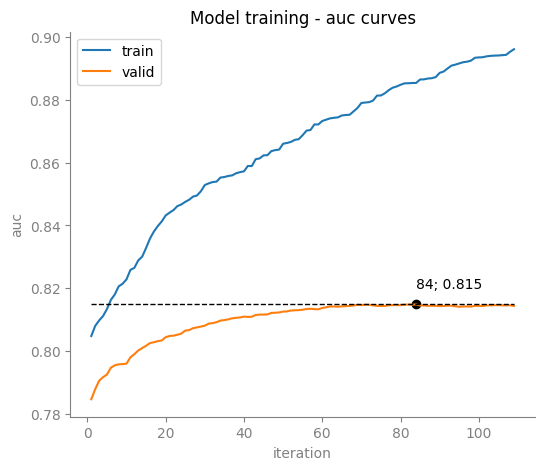

In [193]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1)
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    ax.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1
#best_iteration = 51
ax.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
ax.scatter([best_iteration], [best_score], color = 'black')
ax.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
)
ax.set_xlabel('iteration', color='gray')
ax.set_ylabel(metric, color='gray')
ax.legend(loc='best')
ax.set_title(f'Model training - {metric} curves')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

# plt.savefig('test.svg', format='svg')
# plt.close()

In [151]:
evals_result['test']['auc'][booster.best_iteration+1]

0.821979735132172

# Test values

## Depth:

1:  0.7769588188044859

2:  0.8033817276588686

3:  0.8052946004112226

4:  0.806021934055956

5:  0.8082508632619296

6:  0.8086603942847913

7:  0.8087931030719465

8:  0.8061641922007395

9:  0.8060944000384157

10: 0.8058773294975837

11: 0.8023260052472356

12: 0.7987373020827422

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (16,) and arg 3 with shape (17,).

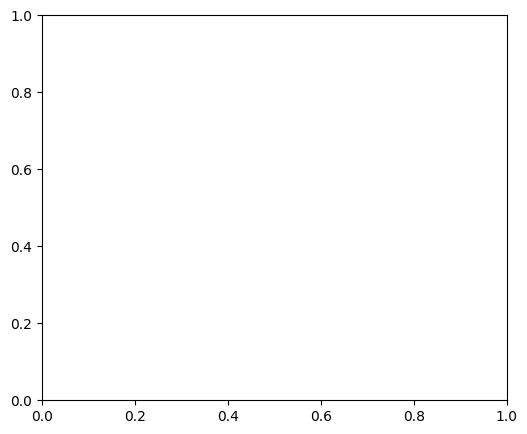

In [194]:
importance_type = 'total_gain'

predictor_strength = sorted([(k, v) for k,v in booster.get_score(importance_type = importance_type).items()], key = lambda x: x[1], reverse = True)
predictor_strength = pd.DataFrame(predictor_strength, columns = ['predictor', 'strength'])

fig = plt.figure(figsize=(6,5))

n_strongest = 17
plt.barh(range(n_strongest, 0, -1), predictor_strength['strength'].iloc[0:17])
plt.yticks(range(n_strongest, 0, -1), predictor_strength['predictor'].iloc[0:17])
plt.xlabel(importance_type)
plt.title('Predictor importance')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

plt.show()
predictor_strength

In [195]:
# Load test data - set index column, decimal point, separator
test_data_file = Path("../Assigment1/Data1/2024_DS2_HW1_data_test.csv")
test_data = pd.read_csv(test_data_file, sep = ',', decimal = '.', index_col = 'Booking_ID')

# print data info
print(f'Number of rows:   {test_data.shape[0]:,}'.replace(',', ' '))
print(f'Number of unique indexes:   {test_data.index.nunique():,}'.replace(',', ' '))
print(f'Number of columns:   {test_data.shape[1]:,}'.replace(',', ' '))

Number of rows:   3 593
Number of unique indexes:   3 593
Number of columns:   17


In [196]:
for pred in tqdm(cols_pred_cat):
    if len(data[pred].unique()) < 0:
        dummies = pd.get_dummies(
            data[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data.columns:
                del data[d]
                
        data = data.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred:
                cols_pred.append(col)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target
        )

        additional_values = set(test_data[test_data[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_booking

        test_data['MTE_' + pred] = test_data[pred].map(new_vals)
        
        if 'MTE_' + pred not in cols_pred:
            cols_pred.append('MTE_' + pred)
        
        if pred in cols_pred:
            cols_pred.remove(pred)

  0%|          | 0/3 [00:00<?, ?it/s]

In [197]:
dtest = xgb.DMatrix(test_data[cols_pred])
ypred = booster.predict(dtest, iteration_range=(0, booster.best_iteration + 1))
ypred

array([0.00289015, 0.21728821, 0.15858302, ..., 0.93683153, 0.01902676,
       0.17809208], dtype=float32)

In [198]:
# Assuming 'booster' is your trained booster and 'data' is your DataFrame

# Predict probabilities on the training data

test_data_reset = test_data.reset_index()

# Create a DataFrame with booking IDs and predicted probabilities
predictions_df = pd.DataFrame({
    'booking_id': test_data_reset['Booking_ID'],  # Assuming 'Booking_ID' is the name of the index
    'predicted_probability': ypred
})
predictions_df

,booking_id,predicted_probability
0,INN04969,0.002890
1,INN34541,0.217288
2,INN36109,0.158583
3,INN01554,0.767543
4,INN24975,0.209634
...,...,...
3588,INN29523,0.021466
3589,INN25061,0.444043
3590,INN08475,0.936832
3591,INN13558,0.019027


In [26]:
#pip install openpyxl

In [168]:
from openpyxl import Workbook

In [199]:
# Export DataFrame to Excel
predictions_df.to_excel("predictions8.xlsx", index=False)

print("DataFrame successfully exported to Excel.")

DataFrame successfully exported to Excel.


<span style="color:red">**TO DO:** change the hyperparameters and observe performance and training</span>

## XGBoost in sklearn

In [29]:
booster_sklearn = xgb.XGBClassifier(
    booster='gbtree', #which booster to use
    objective='binary:logistic', #specify the learning task (objective function)
    random_state=12, #random seed
    verbosity=1, #amount of info in printing
    eval_metric='auc',
    use_label_encoder=False,
    early_stopping_rounds=10,#acttivates early stopping
)

booster_sklearn.fit(
    data[train_mask][cols_pred].values, 
    data[train_mask][col_target].astype(int).values,
    eval_set=[
        (data[train_mask][cols_pred].values, data[train_mask][col_target].values),
        (data[test_mask][cols_pred].values, data[test_mask][col_target].values),
        (data[valid_mask][cols_pred].values, data[valid_mask][col_target].values),
    ],
    verbose=True,
)

[0]	validation_0-auc:0.75377	validation_1-auc:0.74674	validation_2-auc:0.76310
[1]	validation_0-auc:0.77739	validation_1-auc:0.76764	validation_2-auc:0.78126
[2]	validation_0-auc:0.79096	validation_1-auc:0.78100	validation_2-auc:0.78976
[3]	validation_0-auc:0.79588	validation_1-auc:0.78441	validation_2-auc:0.79341
[4]	validation_0-auc:0.79908	validation_1-auc:0.78680	validation_2-auc:0.79617
[5]	validation_0-auc:0.80193	validation_1-auc:0.78865	validation_2-auc:0.79782
[6]	validation_0-auc:0.80813	validation_1-auc:0.79290	validation_2-auc:0.80188
[7]	validation_0-auc:0.81018	validation_1-auc:0.79512	validation_2-auc:0.80382
[8]	validation_0-auc:0.81287	validation_1-auc:0.79745	validation_2-auc:0.80495
[9]	validation_0-auc:0.81487	validation_1-auc:0.79939	validation_2-auc:0.80696
[10]	validation_0-auc:0.81571	validation_1-auc:0.80046	validation_2-auc:0.80801
[11]	validation_0-auc:0.82123	validation_1-auc:0.80168	validation_2-auc:0.81036
[12]	validation_0-auc:0.82231	validation_1-auc:0.8

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=12, ...)

## Final model
Before fitting final model, selection of optimal predictors might be considered. A model with similar performance can be fitted using *n* strongest predictors or using all available predictors. Sometime implementation of the predictors into the production might take some time and therefore you prefer to have "reasonable" number of predictors in your model. On the contrary, having larger number of predictors might bring better robustness - if one of the predictors would broke, the impact for the model would be lower.

For selection of optimal predictors, similar approach as forward (or backward) process can be used.

### Cross validation score

In [30]:
params={
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

skf = StratifiedKFold(n_splits = 2, shuffle = True, random_state = 12)

X = data[cols_pred].values
y = data[col_target].values
data['cv_score'] = -1.0
cv_res = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    evals_result = {}
    booster = xgb.train(
        params = params,
        dtrain = xgb.DMatrix(X_train, y_train),
        num_boost_round = 1000,
        evals = (
            (xgb.DMatrix(X_train, y_train), 'train'),
            (xgb.DMatrix(X_test, y_test), 'test'),
        ),
        evals_result = evals_result,
        early_stopping_rounds = 10,
        verbose_eval = True
    )
    
    gini_train = 2 * roc_auc_score(y_train, booster.predict(xgb.DMatrix(X_train))) - 1
    gini_test  = 2 * roc_auc_score(y_test,  booster.predict(xgb.DMatrix(X_test)))  - 1
    best_iteration = booster.best_iteration
    
    cv_res += [(gini_train, gini_test, best_iteration)]
    
    data.iloc[test_index, list(data.columns).index('cv_score')] = list(booster.predict(xgb.DMatrix(X_test), iteration_range=(0, booster.best_iteration)))

ValueError: Input y contains NaN.

In [31]:
# Performance during cross validation
cv_res

[]

In [32]:
gini_cv = 2 * roc_auc_score(data[col_target], data['cv_score']) - 1
print(f'Cross validation score performance: {gini_cv:.4f}')

D:\Projects\ds2-hw\.venv\lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_true contains NaN.

In [33]:
# Final model
params = {    
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[cols_pred], data[col_target]),
    evals = (
        (xgb.DMatrix(data[cols_pred], data[col_target]), 'train'),
    ),
    num_boost_round = 130,
    evals_result = evals_result
)

XGBoostError: [17:47:32] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\data.cc:507: Check failed: valid: Label contains NaN, infinity or a value too large.

In [34]:
gini_train = 2 * roc_auc_score(data[col_target], booster.predict(xgb.DMatrix(data[cols_pred]))) - 1
print(gini_train)

D:\Projects\ds2-hw\.venv\lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_true contains NaN.

### Final model using splitted data

In [79]:
# Final model
params = {    
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': ['auc'],
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12,
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred],  data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid')
    ),
    evals_result = evals_result,
    early_stopping_rounds = 20,
    verbose_eval = True
)

[0]	train-auc:0.68233	test-auc:0.67915	valid-auc:0.69247
[1]	train-auc:0.72408	test-auc:0.72158	valid-auc:0.73227
[2]	train-auc:0.73076	test-auc:0.72866	valid-auc:0.73505
[3]	train-auc:0.73474	test-auc:0.73053	valid-auc:0.73678
[4]	train-auc:0.74021	test-auc:0.73583	valid-auc:0.74342
[5]	train-auc:0.75160	test-auc:0.74740	valid-auc:0.75699
[6]	train-auc:0.75660	test-auc:0.75250	valid-auc:0.76332
[7]	train-auc:0.76637	test-auc:0.75990	valid-auc:0.77357
[8]	train-auc:0.76609	test-auc:0.75947	valid-auc:0.77272
[9]	train-auc:0.76241	test-auc:0.75509	valid-auc:0.76859
[10]	train-auc:0.76128	test-auc:0.75614	valid-auc:0.77026
[11]	train-auc:0.76630	test-auc:0.76146	valid-auc:0.77418
[12]	train-auc:0.76904	test-auc:0.76388	valid-auc:0.77692
[13]	train-auc:0.76957	test-auc:0.76442	valid-auc:0.77735
[14]	train-auc:0.76888	test-auc:0.76379	valid-auc:0.77695
[15]	train-auc:0.77144	test-auc:0.76561	valid-auc:0.77889
[16]	train-auc:0.77527	test-auc:0.76903	valid-auc:0.78109
[17]	train-auc:0.77523	t

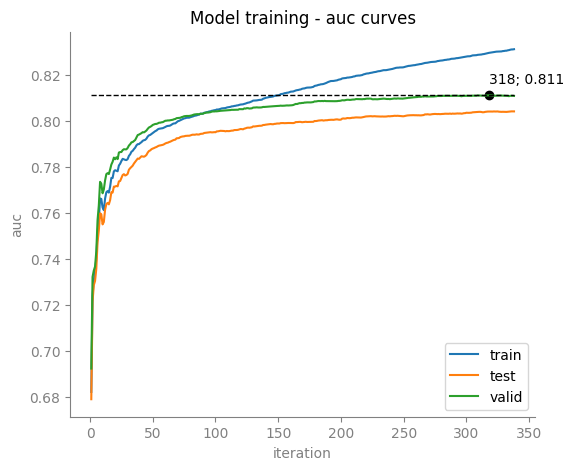

In [80]:
# metric = 'logloss'

# fig, axs = plt.subplots(1,2, figsize = (12,5))
# plt.subplots_adjust(wspace=0.3)

# total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
# for sample, vals in evals_result.items():
#     axs[0].plot(
#         range(1, total_iteration_count + 1), 
#         vals[metric],
#         label=sample
#     )

    
# for sample, vals in evals_result.items():
#     axs[1].plot(
#         range(1, total_iteration_count + 1), 
#         vals['auc'],
#         label=sample
#     )

# best_score = booster.best_score
# best_iteration = booster.best_iteration+1

# plt.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
# plt.scatter([best_iteration], [best_score], color = 'black')
# plt.annotate(
#     '{:d}; {:0.3f}'.format(best_iteration, best_score), 
#     xy = (best_iteration, best_score), 
#     xytext = (best_iteration,best_score+0.005),
# #     textcoords = 'offset points'
# )

# axs[0].set_xlabel('iteration')
# axs[0].set_ylabel('logloss')
# axs[0].set_title(f'logloss curves')

# axs[0].spines['right'].set_visible(False)
# axs[0].spines['top'].set_visible(False)
# axs[0].spines['left'].set_color('gray')
# axs[0].spines['bottom'].set_color('gray')
# axs[0].tick_params(axis='y', colors='gray')
# axs[0].tick_params(axis='x', colors='gray')

# axs[1].set_xlabel('iteration')
# axs[1].set_ylabel('auc')
# axs[1].set_title(f'auc curves')

# axs[1].spines['right'].set_visible(False)
# axs[1].spines['top'].set_visible(False)
# axs[1].spines['left'].set_color('gray')
# axs[1].spines['bottom'].set_color('gray')
# axs[1].tick_params(axis='y', colors='gray')
# axs[1].tick_params(axis='x', colors='gray')

# plt.legend(loc='upper right',  bbox_to_anchor=(0.8, 0.5, 0.5, 0.5))

# plt.show()

metric = 'auc'

fig = plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1)
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    ax.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1
#best_iteration = 51
ax.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
ax.scatter([best_iteration], [best_score], color = 'black')
ax.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
)
ax.set_xlabel('iteration', color='gray')
ax.set_ylabel(metric, color='gray')
ax.legend(loc='best')
ax.set_title(f'Model training - {metric} curves')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

# plt.savefig('test.svg', format='svg')
# plt.close()

#### Applying monotone constraints

<span style="color:red">**TO DO:** Define function for marginal dependence.</span>

Function should have following input parameters:
- data ... pd.DataFrame with data to be used for marginal dependence calculation, TARGET is included in this dataframe
- predictor ... name of the predictor to be analysed
- bins ... number of bins to split the predictor into
- col_target ... the TARGET column to compute default date


It should output a graph with the default rate for each bin, for example
marginal_dependence(data[train_mask], 'EXT_SOURCE_1', 10, col_target) should give something like

<img src="marginal_dependence.png" width=400px style="float: left"/>




In [37]:
def maginal_dependence():
    ...

In [38]:
positive_monotone_constraint = [
]

negative_monotone_constraint = [
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3'
]

constr = []
for col in cols_pred:
    if col in positive_monotone_constraint:
        constr.append('1')
    elif col in negative_monotone_constraint:
        constr.append('-1')
    else:
        constr.append('0')

constr = '(' + ','.join(constr) + ')'
constr

'(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)'

In [39]:
# Final model
params = {    
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'monotone_constraints': constr,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred],  data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid')
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10,
    verbose_eval = True
)

[0]	train-auc:0.68233	test-auc:0.67915	valid-auc:0.69247
[1]	train-auc:0.72408	test-auc:0.72158	valid-auc:0.73227
[2]	train-auc:0.73076	test-auc:0.72866	valid-auc:0.73505
[3]	train-auc:0.73474	test-auc:0.73053	valid-auc:0.73678
[4]	train-auc:0.74021	test-auc:0.73583	valid-auc:0.74342
[5]	train-auc:0.75160	test-auc:0.74740	valid-auc:0.75699
[6]	train-auc:0.75660	test-auc:0.75250	valid-auc:0.76332
[7]	train-auc:0.76637	test-auc:0.75990	valid-auc:0.77357
[8]	train-auc:0.76609	test-auc:0.75947	valid-auc:0.77272
[9]	train-auc:0.76241	test-auc:0.75509	valid-auc:0.76859
[10]	train-auc:0.76128	test-auc:0.75614	valid-auc:0.77026
[11]	train-auc:0.76630	test-auc:0.76146	valid-auc:0.77418
[12]	train-auc:0.76904	test-auc:0.76388	valid-auc:0.77692
[13]	train-auc:0.76957	test-auc:0.76442	valid-auc:0.77735
[14]	train-auc:0.76888	test-auc:0.76379	valid-auc:0.77695
[15]	train-auc:0.77144	test-auc:0.76561	valid-auc:0.77889
[16]	train-auc:0.77527	test-auc:0.76903	valid-auc:0.78109
[17]	train-auc:0.77523	t

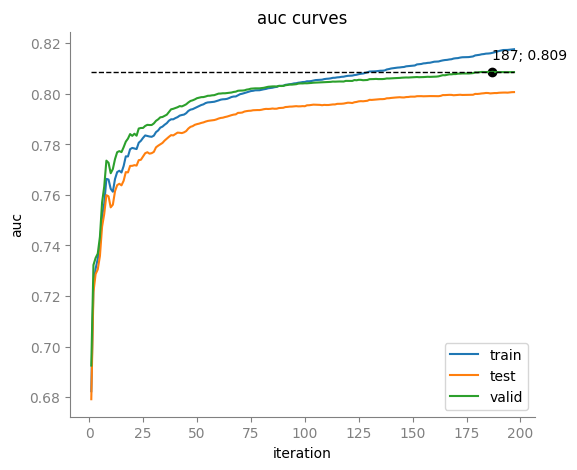

In [40]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    plt.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

plt.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
plt.scatter([best_iteration], [best_score], color = 'black')
plt.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
#     textcoords = 'offset points'
)
plt.xlabel('iteration')
plt.ylabel(metric)
plt.legend(loc='best')
plt.title(f'{metric} curves')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

plt.show()

# Model validation

In [41]:
data['predicted_pd'] = booster.predict(xgb.DMatrix(data[cols_pred]), iteration_range=(0,booster.best_iteration))
data['predicted_score'] = np.log(data['predicted_pd'] / (1 - data['predicted_pd']))

## Plot individual trees

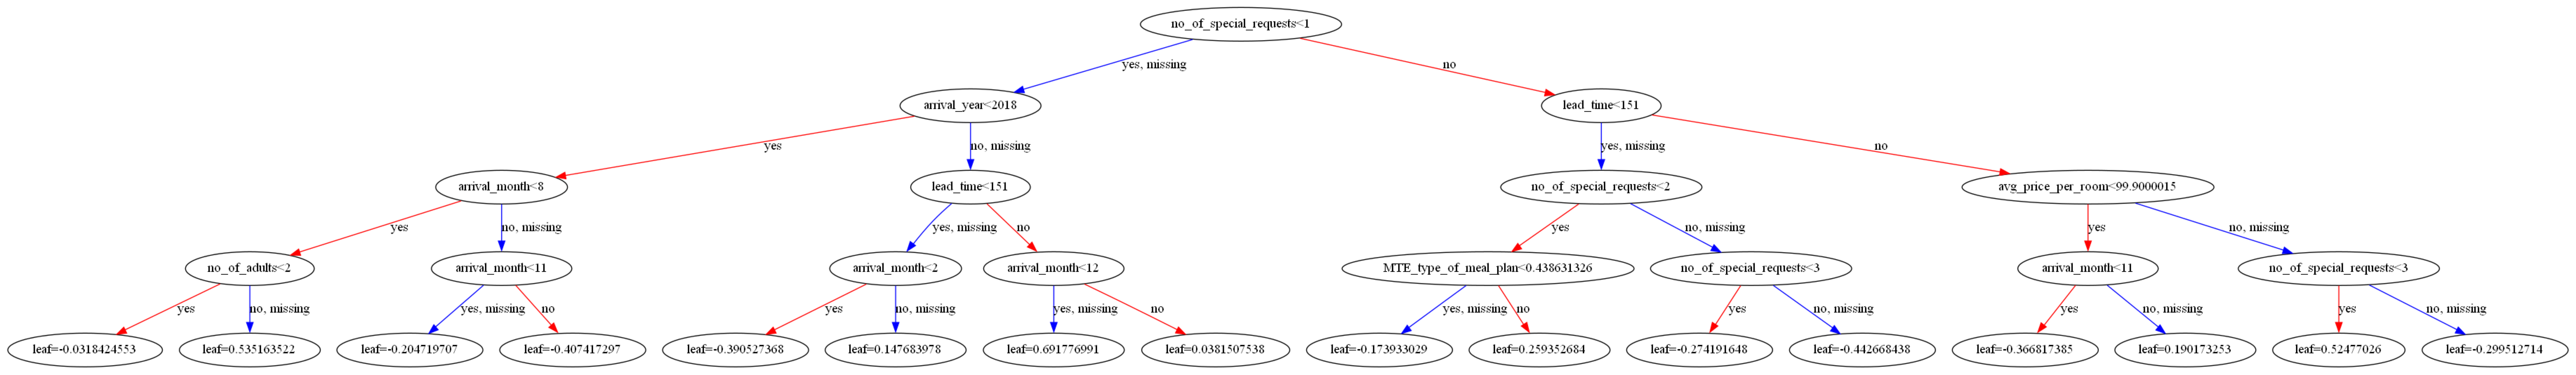

In [72]:
# TODO: To make the following line work you need to install graphviz (if you have not done so in one of the previous classes)
# 1) follow the instructions https://graphviz.gitlab.io/download/?fbclid=IwAR1V-lrRhho5rSfBVYXYISsighqRwOCOgMHLmL_DclkQrPtMXQaKj3mFcqs
# 2) this notebook has been tested with version 8.0.3
# 3) make sure you add it to the PATH variable (you are specifically asked during the installation) at least for local user

from xgboost import plot_tree
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 80,50

plot_tree(booster, num_trees = 0)
plt.show()

rcParams['figure.figsize'] = 5,5

## Score distribution

In [67]:
def plot_score_calibration(dt, col_score, col_target, n_bins = 25):
    min_score = dt[col_score].min() - 0.1
    max_score = dt[col_score].max() + 0.1
    
    bins = [round(min_score + i * (max_score - min_score) / n_bins, 2) for i in range(n_bins+1)]
    dt = dt.assign(score_bin = pd.cut(dt[col_score], bins = bins, include_lowest = False))
    
    dt_grp = dt.groupby('score_bin', observed=False).agg(
        bad_cnt = (col_target, 'sum'),
        tot_cnt = (col_target, len),
        def_rt = (col_target, 'mean'),
        avg_score = (col_score, 'mean')
    )
    dt_grp['good_cnt'] = dt_grp['tot_cnt'] - dt_grp['bad_cnt']
    dt_grp['bad_cnt_norm'] = dt_grp['bad_cnt'] / dt_grp['tot_cnt']
    dt_grp['good_cnt_norm'] = dt_grp['good_cnt'] / dt_grp['tot_cnt']
    dt_grp['expected_pd'] = 1 / (1 + np.exp(-dt_grp['avg_score']))
    
    fig, axs = plt.subplots(1,2, figsize = (12,4))
    fig.suptitle(col_score)
    plt.subplots_adjust(wspace = 0.4)
    axs[0].bar(range(len(dt_grp)), dt_grp['bad_cnt'], color = 'salmon', label = 'bads')
    axs[0].bar(range(len(dt_grp)), dt_grp['good_cnt'], bottom = dt_grp['bad_cnt'], color = 'lightblue', label = 'goods')
    axs[0].set_ylabel('observations count')
    axs[0].set_xlabel('score')
    axs[0].set_xticks(range(len(dt_grp)))
    axs[0].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[0].spines['right'].set_color('gray')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['left'].set_color('gray')
    axs[0].spines['bottom'].set_color('gray')
    axs[0].tick_params(axis='y', colors='gray')
    axs[0].tick_params(axis='x', colors='gray')
    
    ax0l = axs[0].twinx()
    ax0l.plot(range(len(dt_grp)), dt_grp['def_rt'], marker = 'o', color = 'red')
    ax0l.plot(range(len(dt_grp)), dt_grp['expected_pd'], color = 'black', ls = '--')
    ax0l.set_ylabel('default rate', color = 'red')
    
    ax0l.spines['right'].set_color('gray')
    ax0l.spines['top'].set_visible(False)
    ax0l.spines['left'].set_color('gray')
    ax0l.spines['bottom'].set_color('gray')
    ax0l.tick_params(axis='y', colors='gray')
    ax0l.tick_params(axis='x', colors='gray')
    
    axs[1].bar(range(len(dt_grp)), dt_grp['bad_cnt_norm'], color = 'salmon', label = 'bads')
    axs[1].bar(range(len(dt_grp)), dt_grp['good_cnt_norm'], bottom = dt_grp['bad_cnt_norm'], color = 'lightblue', label = 'goods')
    axs[1].set_ylabel('frequency')
    axs[1].set_xlabel('score')
    axs[1].set_xticks(range(len(dt_grp)))
    axs[1].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['left'].set_color('gray')
    axs[1].spines['bottom'].set_color('gray')
    axs[1].tick_params(axis='y', colors='gray')
    axs[1].tick_params(axis='x', colors='gray')

In [68]:
plot_score_calibration(data[valid_mask | test_mask], 'predicted_score', col_target)

KeyError: 'predicted_score'

## Permutation importance
- Let's have dataset $D$ and model with score (AUC for instance) $s$
- For each feature $j$ calculate permutation importance as follows:
    - for $k$ in $1,\ldots,K$:
        - shuffle column $j$ in dataset $D$ -> $\hat{D}_{k,j}$
        - compute the score $s_{k,j}$ using $\hat{D}_{k,j}$
    - importance $i_j$ for feature $f_j$ is defined as:
$$i_j = s - \frac{1}{K}\sum_{k=1}^K s_{k,j}$$

In [35]:
from sklearn.inspection import permutation_importance

In [36]:
# for sklearn, there is a function
r = permutation_importance(booster_sklearn, data[test_mask][cols_pred], data[test_mask][col_target], n_repeats=6)

In [37]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{cols_pred[i]:<8}    "
              f"{r.importances_mean[i]:.4f}"
              f" +/- {r.importances_std[i]:.4f}")

AMT_CREDIT    0.0005 +/- 0.0002
LAST_TRANSACTION_TIME_MONTHS    0.0002 +/- 0.0001
YEARS_BEGINEXPLUATATION_MEDI    0.0001 +/- 0.0000


In [38]:
def permutation_importance(dt, predictor, target, model, n_iters = 10):
    predictors = list(dt.columns)
    predictors.remove(target)
    
    prediction = model.predict(xgb.DMatrix(dt[predictors]), iteration_range=(0,model.best_iteration))
    s = roc_auc_score(dt[target], prediction)
    
    sk = []
    for i in range(n_iters):
        x = dt[predictor].to_list()
        np.random.shuffle(x)
        dt[predictor] = x
        prediction = model.predict(xgb.DMatrix(dt[predictors]), iteration_range=(0,model.best_iteration))
        sk.append(roc_auc_score(dt[target], prediction))
    
    sk_mean = np.mean(sk)
    sk_perc05 = np.percentile(sk, q=5)
    sk_perc95 = np.percentile(sk, q=95)
    
    return s - sk_mean, s - sk_perc05, s - sk_perc95    

In [39]:
res = []
for pred in tqdm(cols_pred[0:10]):
    pi, iqr95, iqr05 = permutation_importance(
        dt=data[test_mask][cols_pred + [col_target]], 
        predictor=pred,
        target=col_target,
        model=booster,
        n_iters=10
    )
    res.append((pred, pi, iqr05, iqr95))
res = pd.DataFrame(res, columns = ['predictor', 'permutation_importance', 'iqr05', 'iqr95'])
res

  0%|          | 0/10 [00:00<?, ?it/s]

,predictor,permutation_importance,iqr05,iqr95
0,CNT_CHILDREN,0.000055,-0.000031,0.000175
1,AMT_INCOME_TOTAL,-0.000091,-0.000190,0.000040
2,AMT_CREDIT,0.005137,0.003112,0.007115
3,AMT_ANNUITY,0.003547,0.002582,0.005227
4,AMT_GOODS_PRICE,0.008705,0.006394,0.011931
5,REGION_POPULATION_RELATIVE,0.000018,-0.000201,0.000282
6,DAYS_BIRTH,0.002190,0.001383,0.003270
7,DAYS_EMPLOYED,0.002630,0.001919,0.003418
8,DAYS_REGISTRATION,0.000174,-0.000522,0.000813
9,DAYS_ID_PUBLISH,0.001644,0.000670,0.002513


## Marginal contribution

In [40]:
def fit_model(predictors):
    params={
        'eta': 0.2,
        'max_depth': 3,

        'eval_metric': 'auc',
        'objective': 'binary:logistic' ,
        'booster': 'gbtree',
        'tree_method': 'hist',

        'base_score': 0.08,

        'seed': 12
    }

    evals_result = {}

    booster_mc = xgb.train(
        params = params,
        dtrain = xgb.DMatrix(data[train_mask][predictors], data[train_mask][col_target]),
        num_boost_round = 1000,
        evals = (
            (xgb.DMatrix(data[train_mask][predictors], data[train_mask][col_target]), 'train'),
            (xgb.DMatrix(data[test_mask][predictors], data[test_mask][col_target]), 'test'),
            (xgb.DMatrix(data[valid_mask][predictors], data[valid_mask][col_target]), 'valid')
        ),
        evals_result = evals_result,
        early_stopping_rounds = 20
    )
    
    
    prediction = booster_mc.predict(xgb.DMatrix(data[test_mask][predictors]))
    return roc_auc_score(data[test_mask][col_target], prediction)

prediction = booster.predict(xgb.DMatrix(data[test_mask][cols_pred]), iteration_range=(0,booster.best_iteration))
auc_base = roc_auc_score(data[test_mask][col_target], prediction)

marginal_contribution = []
for pred in tqdm(cols_pred[0:5]):
    auc = fit_model(predictors=[p for p in cols_pred if p != pred])
    marginal_contribution.append((pred, auc_base - auc))

  0%|          | 0/5 [00:00<?, ?it/s]

[0]	train-auc:0.68472	test-auc:0.67386	valid-auc:0.68360
[1]	train-auc:0.70874	test-auc:0.68973	valid-auc:0.71066
[2]	train-auc:0.71631	test-auc:0.69490	valid-auc:0.71795
[3]	train-auc:0.72251	test-auc:0.69895	valid-auc:0.72242
[4]	train-auc:0.72644	test-auc:0.70214	valid-auc:0.72619
[5]	train-auc:0.72893	test-auc:0.70454	valid-auc:0.72746
[6]	train-auc:0.73252	test-auc:0.70720	valid-auc:0.72960
[7]	train-auc:0.73522	test-auc:0.70999	valid-auc:0.73168
[8]	train-auc:0.73686	test-auc:0.71063	valid-auc:0.73251
[9]	train-auc:0.74160	test-auc:0.71394	valid-auc:0.73608
[10]	train-auc:0.74294	test-auc:0.71564	valid-auc:0.73677
[11]	train-auc:0.74560	test-auc:0.71703	valid-auc:0.73830
[12]	train-auc:0.74756	test-auc:0.71876	valid-auc:0.73954
[13]	train-auc:0.74941	test-auc:0.71975	valid-auc:0.74115
[14]	train-auc:0.75104	test-auc:0.72109	valid-auc:0.74173
[15]	train-auc:0.75291	test-auc:0.72230	valid-auc:0.74265
[16]	train-auc:0.75508	test-auc:0.72326	valid-auc:0.74438
[17]	train-auc:0.75604	t

In [41]:
marginal_contribution = sorted(marginal_contribution, key=lambda x: x[1], reverse=False)

In [42]:
marginal_contribution

[('AMT_ANNUITY', 0.003294343459197435),
 ('CNT_CHILDREN', 0.004005871015915763),
 ('AMT_INCOME_TOTAL', 0.004469701186495367),
 ('AMT_CREDIT', 0.0046338794839145825),
 ('AMT_GOODS_PRICE', 0.006407799507157974)]

In [ ]:
# feature_perm_importance = sorted(zip(cols_pred, pi['importances_mean']), key=lambda x: x[1], reverse=False)

plt.figure(figsize=(6,10))
ax = plt.subplot(1,1,1)
ax.barh(range(len(marginal_contribution)), [imp for p, imp in marginal_contribution])
ax.set_yticks(range(len(marginal_contribution)))
ax.set_yticklabels([p for p, imp in marginal_contribution])

ax.set_title('Feature marginal contribution')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='x', colors='gray')
ax.tick_params(axis='y', colors='gray')

plt.show()

## PDP plots
- PDP = Partial Dependence Plot

In [ ]:
def partial_dependency(bst, X, y, feature_names, feature_ids = [], f_id = -1):

    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    """
    X_temp = X.copy()
    grid = np.linspace(
        np.percentile(X_temp[:, f_id], 0.1),
        np.percentile(X_temp[:, f_id], 99.5),
        50
    )
    y_pred = np.zeros(len(grid))

    if len(feature_ids) == 0 or f_id == -1:
        print ('Input error!')
        return
    else:
        for i, val in enumerate(grid):

            X_temp[:, f_id] = val
            data = xgb.DMatrix(X_temp, feature_names = feature_names)

            y_pred[i] = np.average(bst.predict(data))

    return grid, y_pred

In [ ]:
lst_f = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']
# cols_pred
sampled_data = data.sample(frac=0.1, random_state=22)
for f in lst_f:
    f_id = cols_pred.index(f)
    feature_ids = range(len(cols_pred))

    mask = sampled_data[f].notnull()
    grid, y_pred = partial_dependency(
        booster,
        sampled_data[mask][cols_pred].values,
        sampled_data[mask][col_target].values,
        feature_names = cols_pred,
        feature_ids = feature_ids,
        f_id = f_id
    )

    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    plt.subplots_adjust(left = 0.17, right = 0.94, bottom = 0.15, top = 0.9)

    ax.plot(grid, y_pred, ls = '-', color = 'red', linewidth = 1.5, label='fit')

    ax.set_xlim(min(grid), max(grid))
    ax.set_ylim(0.98 * min(y_pred), 1.02 * max(y_pred))

    ax.set_title(f)
    ax.set_ylabel('Partial Dependence')
    plt.xticks(rotation=45)

    plt.show()

## ICE plots
- ICE = Individual Conditional Expectation

In [ ]:
def ice_data(bst, dt, predictor, n_points=20):
    X = dt.copy()
    grid = np.linspace(
        dt[predictor].quantile(0.01),
        dt[predictor].quantile(0.99),
        n_points
    )
    
    y_pred = np.zeros((len(dt), len(grid)))

    if len(feature_ids) == 0 or f_id == -1:
        print ('Input error!')
        return
    else:
        for i, val in enumerate(grid):
            X[predictor] = val
            data = xgb.DMatrix(X, feature_names = X.columns.to_list())

            y_pred[:,i] = bst.predict(data)

    return grid, y_pred

In [ ]:
n_plots = 100
cols_to_plot = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']

sampled_data = data.sample(n=10000, random_state=22)

for pred in cols_to_plot:
    x, ice_data_plot = ice_data(booster, sampled_data[cols_pred], pred)

    idx = np.random.randint(len(x), size=n_plots)
    plt.plot(x, np.transpose(ice_data_plot[idx,:]), lw = 0.5, color = 'lightblue')
    plt.plot(x, np.average(ice_data_plot[idx,:], axis = 0), lw = 2, ls = '--', color = 'blue', label = 'Partial dependance curve')
    plt.title(pred)
    plt.ylabel('Predicted value')
    plt.xlabel('Values')
    plt.legend(loc='best')
    plt.show()

## SHAP
- SHAP = SHapley Additive exPlanations
- Original paper presenting SHAP values can be downloaded here: <a href=https://arxiv.org/abs/1705.07874 target="_blank">SHAP values</a>
- SHAP values are defined by following equation:
$$ \phi_i = \sum_{S\subseteq F\setminus\lbrace i \rbrace} \frac{|S|!(|F|-|S|-1)!}{|F|!} [f_{S\cup \lbrace i\rbrace}(x_{S\cup \lbrace i\rbrace})-f_S(x_S)] $$
where:

    - $F$ ... set of all model features
    - $S$ ... $S \subseteq F \setminus\lbrace i\rbrace$
    - $\phi_i$ ... SHAP value for predictor $x_i$
    - $f_S(x_S)$ ... output of model build on feature set $S$ given feature values $x_S$

In [ ]:
import shap
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(data[cols_pred])

In [ ]:
plt.figure()
shap.summary_plot(shap_values, data[cols_pred], max_display=20, show=True)
plt.show()

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], data[cols_pred].iloc[0,:])

In [ ]:
shap.plots._waterfall.waterfall_legacy(
    expected_value=explainer.expected_value, 
    shap_values=shap_values[0, :], 
    feature_names=cols_pred, 
    max_display=20
)

### SHAP interaction values

In [ ]:
Xd = xgb.DMatrix(data[train_mask][cols_pred].iloc[:1000], data[train_mask][col_target].iloc[:1000])

explainer = shap.TreeExplainer(booster)
shap_interaction_values = explainer.shap_interaction_values(Xd)

In [ ]:
plt.figure(figsize=(15,13))

sns.heatmap(
    data=np.mean(abs(shap_interaction_values[:, 0:20, 0:20]), axis=0), 
    annot=True, 
    fmt='.2f', 
    xticklabels=cols_pred[0:20], 
    yticklabels=cols_pred[0:20],
    cmap='winter',
    vmax=0.05
)

plt.show()

In [ ]:
n_observations = 10000

dt_shap = data.iloc[0:n_observations]
dt_shap = dt_shap[cols_pred]
shap.dependence_plot('AMT_GOODS_PRICE', shap_values[:n_observations], dt_shap, interaction_index = 'AMT_CREDIT')

Better example of high interaction: https://h1ros.github.io/posts/explain-the-interaction-values-by-shap/

In [ ]:
# def marginal_dependence(data, predictor, bins, col_target):
#     dt = data.copy()
#     dt[predictor + 'bin'] = pd.qcut(dt[predictor], bins).copy()
#     dt.groupby(predictor + 'bin').agg(
#         def_rt=(col_target, np.mean),
#     ).plot(figsize=(9, 6))